In [2]:
import glob
import os
from os.path import join, basename
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange
from monai.networks.nets import UNet
from skimage.transform import resize
from tqdm import tqdm
import itertools

In [25]:
# Your file paths
DATAROOT = r"E:\Documentos\01_DTU\DTU-TFM\Fotos\DOE\1\2"

image_files = sorted(glob.glob(join(DATAROOT, 'Imagessamesize', '*.jpg')))
label_files = sorted(glob.glob(join(DATAROOT, 'thresholded_images', '*.jpg'))) 

# Load Images
images = []
labels = []

# New size for the resized images
new_size = (int(2048/2), int(2048/2))

for image_file, label_file in tqdm(zip(image_files, label_files), desc="Loading Images"):
    # Load image
    image = imread(image_file).astype('float32') / 255.0
    
    # Resize image
    resized_image = resize(image, new_size, anti_aliasing=True)
    
    # Load label
    label = imread(label_file)
    
    # Resize label to match the new size
    resized_label = resize(label, new_size, anti_aliasing=True)
    
    # Append to lists
    images.append(resized_image)
    labels.append(resized_label)

# Convert lists to arrays
images = np.array(images)
labels = np.array(labels)

# Check the shape of the first resized image and label
print("Shape of the first resized image:", images[0].shape)
print("Shape of the first resized label:", labels[0].shape)

Loading Images: 0it [00:00, ?it/s]

Loading Images: 74it [01:24,  1.14s/it]


Shape of the first resized image: (1024, 1024, 3)
Shape of the first resized label: (1024, 1024)


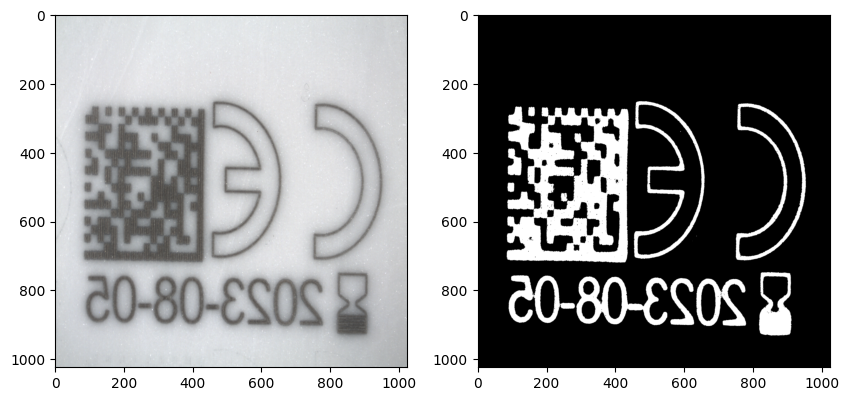

In [26]:
# View images and associated labels
fig, ax = plt.subplots(1, 2, figsize=(10, 22))
ax[0].imshow(images[0], cmap='gray')
ax[1].imshow(labels[0], cmap='gray')
plt.show()

In [27]:
# Check if CUDA is available
print(torch.backends.cudnn.enabled)
torch.cuda.is_available()

True


True

In [28]:
from monai.networks.nets import UNet

model = UNet(
   spatial_dims=2, # TODO: Change this
   in_channels=3,  # TODO: Change this
   out_channels=2, # TODO: Change this
   channels=(32, 64, 128, 256), # Adjust based on your requirements
   strides=(2, 2, 2), # TODO: Change this
   kernel_size=3,
   
)

orig_state = model.state_dict()  # Save, so we can reset model to original state later

In [29]:
images_torch = [torch.from_numpy(x).permute(2, 0, 1).float() for x in images]
labels_torch = [torch.from_numpy(x).long() for x in labels]

for tensor in images_torch:
    print(tensor.shape)

for tensor in labels_torch:
    print(tensor.shape)

torch.cuda.empty_cache()

torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 1024,

In [30]:
# Perform transformations

from monai.transforms import (
    Compose,
    EnsureType,
    NormalizeIntensity,
    RandAffine,
    RandAdjustContrast,
    RandFlip,
    RandRotate90,
)

train_img_transforms = Compose([
    RandFlip(prob=0.5, spatial_axis=0),
    RandRotate90(prob=0.5, max_k=3),
    RandAffine(prob=0.5, translate_range=5),
    RandAdjustContrast(prob=0.5, gamma=(0.4, 2)),
    NormalizeIntensity(subtrahend=0.5, divisor=0.5),
])

train_seg_transforms = Compose([
    RandFlip(prob=0.5, spatial_axis=0),
    RandRotate90(prob=0.5, max_k=3),
    RandAffine(prob=0.5, translate_range=5),
    # Add other spatial transforms here, if needed
])

# Use the same order of transforms for input and target in Compose
train_transforms = Compose([
    EnsureType(),
    (train_img_transforms, EnsureType()),  # EnsureType() is used to enforce tensor type consistency
    (train_seg_transforms, EnsureType()),
])


val_img_trasnforms = Compose([
    NormalizeIntensity(subtrahend=0.5, divisor=0.5),  # Normalize to [-1, 1]
])

In [31]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Separate images and labels
    images, labels = zip(*batch)
    
    # Pad images and labels to the same size
    images = pad_sequence(images, batch_first=True)
    labels = pad_sequence(labels, batch_first=True)
    
    return images, labels

In [32]:
from monai.data import ArrayDataset
from torch.utils.data import DataLoader

TRAIN_BATCH_SIZE = 15
VAL_BATCH_SIZE = 3

split_idx = 20  # Roughly 2/3 of the data
train_data = ArrayDataset(img=images_torch[:split_idx], seg=labels_torch[:split_idx], img_transform=train_img_transforms)
val_data = ArrayDataset(img=images_torch[split_idx:], seg=labels_torch[split_idx:], img_transform=val_img_trasnforms)

train_loader = DataLoader(dataset=train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset=val_data, batch_size=VAL_BATCH_SIZE, num_workers=0, pin_memory=True, collate_fn=collate_fn)

In [33]:
loss_fn = nn.CrossEntropyLoss()

In [34]:
NUM_EPOCHS = 20
EVAL_EVERY = 1
PRINT_EVERY = 1
LR = 3e-3

model.load_state_dict(orig_state)  # Restart training every time
model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

all_losses = []
all_val_loss = []
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    step = 0
    for inputs, targets in train_loader:
        inputs = inputs.cuda()
        targets = targets.cuda().squeeze().long()

        # Forward -> Backward -> Step
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach()
        step += 1
        
    # Log and store average epoch loss
    epoch_loss = epoch_loss.item() / step
    all_losses.append(epoch_loss)

    if epoch % EVAL_EVERY == 0:
        model.eval()
        with torch.no_grad():  # Do not need gradients for this part
            loss_sum = 0
            step = 0
            for inputs, targets in val_loader:
                inputs = inputs.cuda()
                targets = targets.cuda().squeeze().long()

                outputs = model(inputs)
                
                loss_sum += loss_fn(outputs, targets)
                step += 1
                
            val_loss = loss_sum.item() / step
            all_val_loss.append(val_loss)

        # Log and store average accuracy
        if epoch % PRINT_EVERY == 0:
            print(f'Epoch {epoch: 3}, train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}')

print('Min val loss:', min(all_val_loss))

OutOfMemoryError: CUDA out of memory. Tried to allocate 480.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.77 GiB is allocated by PyTorch, and 17.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

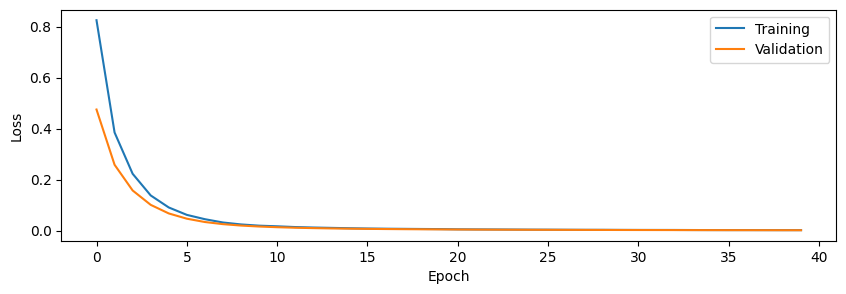

In [ ]:
# Visualize training process

plt.figure(figsize=(10, 3))
plt.plot(all_losses, '-', label='Training')
plt.plot(all_val_loss, '-', label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
torch.save(model, f'./unet02.pt')

In [3]:
# Load the saved model
loaded_model = torch.load('./unet01.pt')
loaded_model.eval()  # Set the model to evaluation mode

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(128, eps=1e-05,

In [4]:
from PIL import Image
import os
import numpy as np

def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            images.append(img)
    return images

# Load images from the specified directory
image_directory = r'E:\Documentos\01_DTU\DTU-TFM\Fotos\DOE\1\3'
new_images = load_images_from_directory(image_directory)

In [7]:

from skimage.transform import resize
# Preprocess and make predictions
new_images = [np.array(img).astype('float32') / 255.0 for img in new_images]
new_images = [resize(img, (1024, 1024, 3), anti_aliasing=True) for img in new_images]
new_images = [torch.from_numpy(img).permute(2, 0, 1).float() for img in new_images]
new_images = new_images[:5]

# Inspect predictions for the first 5 images in new_images
num_images = 2  # Choose a smaller number if needed

loaded_model.eval()

fig, axes = plt.subplots(3, num_images, figsize=(15, 15))

for i in range(num_images):
    # Load and preprocess the image
    im = new_images[i].unsqueeze(0).cuda()

    # Display the original image
    axes[0, i].imshow(new_images[i].permute(1, 2, 0))
    axes[0, i].axis('off')

    # Make predictions
    with torch.no_grad():
        pred = loaded_model(im)
    pred = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

    # Display the prediction
    axes[1, i].imshow(pred, cmap='viridis', alpha=0.5)
    axes[1, i].axis('off')



plt.show()



MemoryError: Unable to allocate 4.00 GiB for an array with shape (1024, 1024, 1024) and data type float32

In [ ]:
# Inspect predictions

num_images = 2

model.eval()

fig, axes = plt.subplots(3, num_images, figsize=(5, 5))

for i in range(num_images):
    
    im, lb = train_data[i]
    [axes[j, i].imshow(im[0] [100,:,:], cmap='gray') for j in range(3)]

    with torch.no_grad():
        pred = model(im.unsqueeze(0).cuda())
    pred = pred.cpu().numpy()[0].argmax(axis=0)
    
    axes[1, i].imshow(pred, cmap='viridis', alpha=0.5)
    axes[2, i].imshow(lb, cmap='viridis', alpha=0.5)
    
plt.show()